In [1]:
import pandas as pd
import IPython.display as display

In [2]:
import pandas as pd
# Load the CSV file into a DataFrame and display it
df = pd.read_csv('AugSept copy.csv')
#df.head(5000)

In [3]:
# Make sure DT is sorted and is a datetime object
df['Transfer Date'] = pd.to_datetime(df['Transfer Date'])
df = df.sort_values('Transfer Date')
df = df.sort_values('Instrument').reset_index(drop=True)

#Make values in Trade Amount column numeric
df['Trade Amount'] = pd.to_numeric(
    df['Trade Amount'].astype(str)
               .str.replace(r'[^\d.-]', '', regex=True)  # remove literally anything that's not digit or dot or dash
               .str.strip(),
    errors='coerce'
)

/tmp/ipykernel_850/859932868.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Transfer Date'] = pd.to_datetime(df['Transfer Date'])


In [4]:
# Calculate direction from buy/sell and signed trade value
df['Direction'] = df['Buy/Sell'].map({'Buy': 1, 'Sell': -1})
df['Signed'] = df['Direction'] * df['Trade Amount']

# Calculate the cumulative position overall
df['CP Overall'] = df.groupby('Instrument')['Signed'].cumsum()

# monthly
df['YearMonth'] = df['Transfer Date'].dt.to_period('M')
df['CP Monthly'] = df.groupby(['Instrument', 'YearMonth'])['Signed'].cumsum()
# weekly 
df['YearWeek'] = df['Transfer Date'].dt.to_period('W')  
df['CP Weekly'] = df.groupby(['Instrument', 'YearWeek'])['Signed'].cumsum()


> SORT by transfer date. Please plot Cumulative Position (CP Overall) for each df['Instrument'], plot a separate subplot for each instrument. Black background with neon colors.

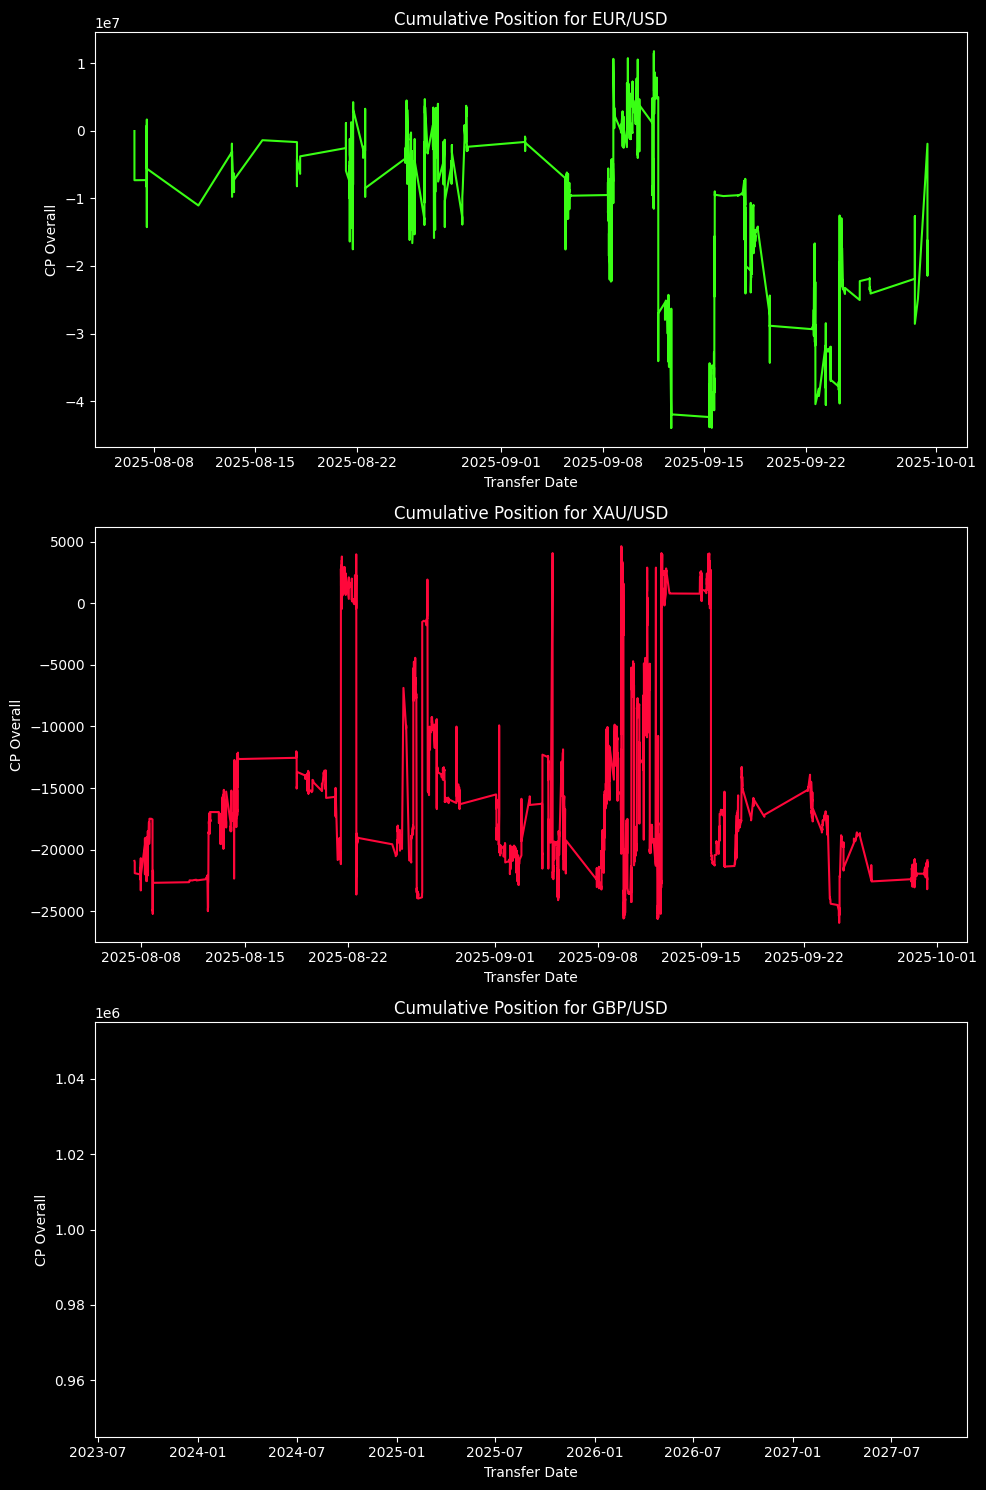

In [5]:
import matplotlib.pyplot as plt

#sort data by transfer date and instrument
df = df.sort_values(by=['Transfer Date', 'Instrument'])
# Set the style for the plot
plt.style.use('dark_background')

# Define neon colors
neon_colors = ['#39FF14', '#FF073A', '#FF61F6', '#0FF0FC', '#F4F724']

# get each instrument in the data
unique_instruments = df['Instrument'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=len(unique_instruments), ncols=1, figsize=(10, 5 * len(unique_instruments)))

# Plot each instrument in a separate subplot
for ax, instrument, color in zip(axes, unique_instruments, neon_colors):
    instrument_data = df[df['Instrument'] == instrument]
    ax.plot(instrument_data['Transfer Date'], instrument_data['CP Overall'], color=color)
    ax.set_title(f'Cumulative Position for {instrument}')
    ax.set_xlabel('Transfer Date')
    ax.set_ylabel('CP Overall')

plt.tight_layout()
plt.show()

> Produce Cumulative P/L in the exact same code format that CP Overall, Weekly, Monthly was created. Create CPL Overall, CPL Daily, CPL Weekly, CPL Monthly. Handle the en, or em dash as 0 in the data. convert to numeric.

In [6]:
df['Settled PL'] = df['Settled PL'].replace({'–': '0', '—': '0'})

# Remove commas and convert to numeric, handle negative numbers
# Use regex to remove commas and convert to float
# The regex pattern will handle negative numbers correctly
# by removing commas and converting the string to float

df['Settled PL'] = df['Settled PL'].str.replace(',', '')
df['Settled PL'] = pd.to_numeric(df['Settled PL'], errors='coerce')

# Calculate CPL Overall
df['CPL Overall'] = df.groupby('Instrument')['Settled PL'].cumsum()

# Calculate CPL Daily
df['Trade_Day'] = pd.to_datetime(df['Transfer Date']).dt.date
df['CPL Daily'] = df.groupby(['Instrument', 'Trade_Day'])['Settled PL'].cumsum()

# Calculate CPL Weekly
df['CPL Weekly'] = df.groupby(['Instrument', 'YearWeek'])['Settled PL'].cumsum()

# Calculate CPL Monthly
df['CPL Monthly'] = df.groupby(['Instrument', 'YearMonth'])['Settled PL'].cumsum()

#df.head(5000)

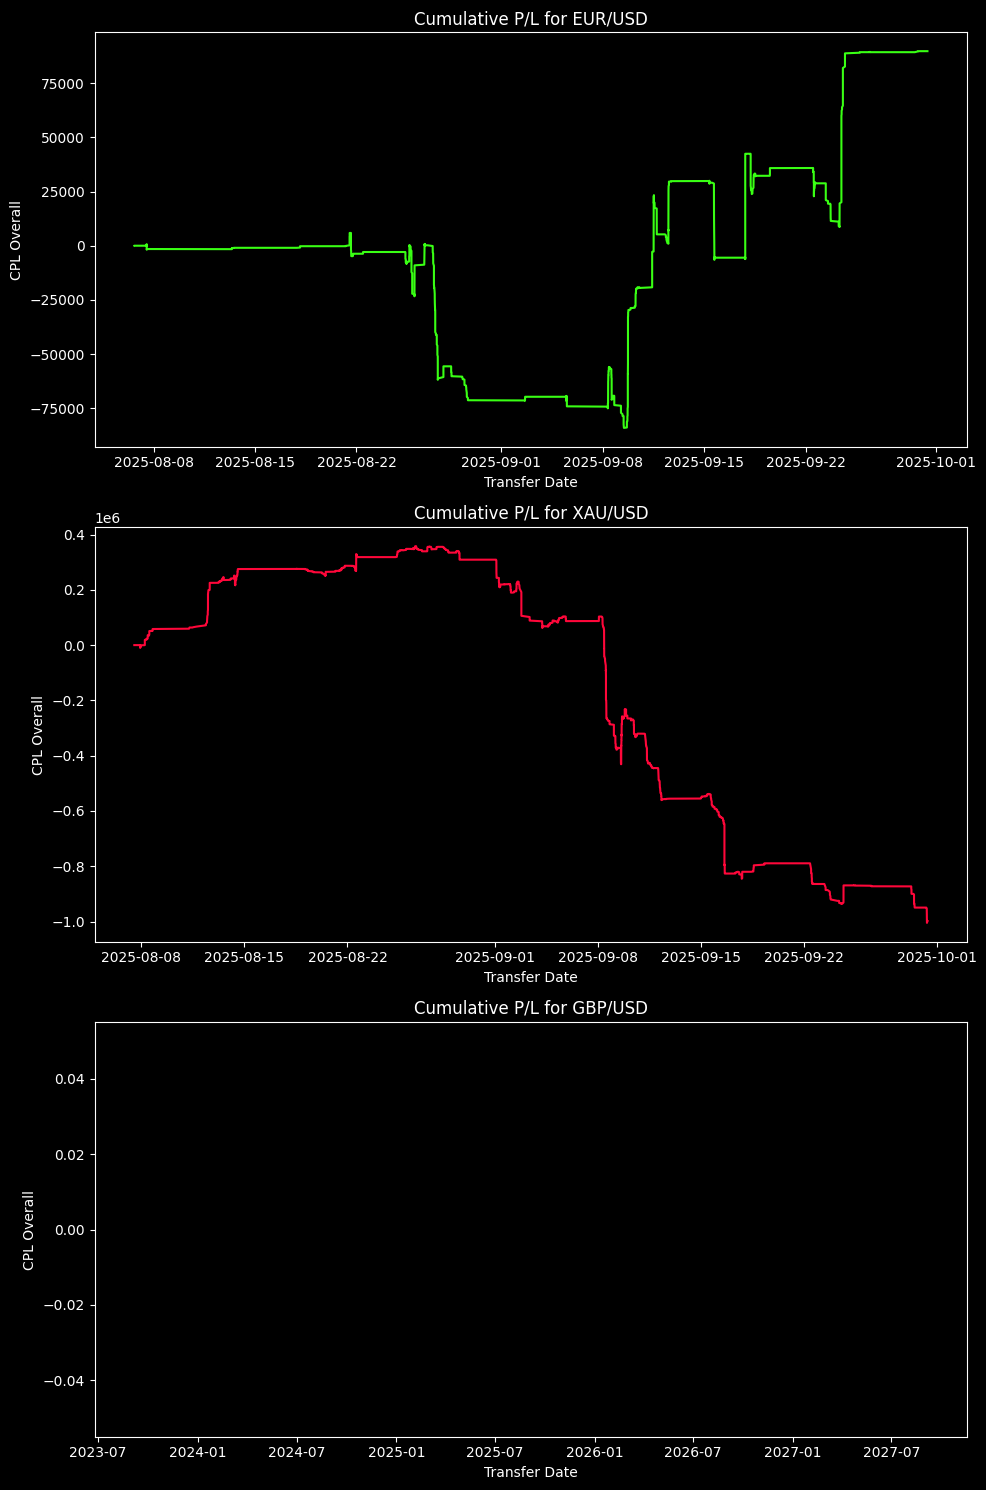

In [7]:
# Plot CPL Overall for each instrument

# Create subplots
fig, axes = plt.subplots(nrows=len(unique_instruments), ncols=1, figsize=(10, 5 * len(unique_instruments)))

# Plot each instrument in a separate subplot
for ax, instrument, color in zip(axes, unique_instruments, neon_colors):
    instrument_data = df[df['Instrument'] == instrument]
    ax.plot(instrument_data['Transfer Date'], instrument_data['CPL Overall'], color=color)
    ax.set_title(f'Cumulative P/L for {instrument}')
    ax.set_xlabel('Transfer Date')
    ax.set_ylabel('CPL Overall')

plt.tight_layout()
plt.show()

In [8]:
# 1. Create Daily Summary
daily_df = df.groupby(['Instrument', 'Trade_Day'])[['CPL Daily']].last().reset_index()

# 2. Create Weekly Summary
weekly_df = df.groupby(['Instrument', 'YearWeek'])[['CP Weekly', 'CPL Weekly']].last().reset_index()

# 3. Create Monthly Summary
monthly_df = df.groupby(['Instrument', 'YearMonth'])[['CP Monthly', 'CPL Monthly']].last().reset_index()

daily_df.head(), weekly_df.head(), monthly_df.head()

(  Instrument   Trade_Day  CPL Daily
 0    EUR/USD  2025-08-06       6.00
 1    EUR/USD  2025-08-07   -1529.41
 2    EUR/USD  2025-08-11     -59.65
 3    EUR/USD  2025-08-13     624.40
 4    EUR/USD  2025-08-15       0.00,
   Instrument               YearWeek  CP Weekly  CPL Weekly
 0    EUR/USD  2025-08-04/2025-08-10 -5075000.0    -1523.41
 1    EUR/USD  2025-08-11/2025-08-17  -840000.0      564.75
 2    EUR/USD  2025-08-18/2025-08-24   149000.0    -1936.63
 3    EUR/USD  2025-08-25/2025-08-31  9313000.0   -68444.84
 4    EUR/USD  2025-09-01/2025-09-07 -6560000.0    -2822.98,
   Instrument YearMonth  CP Monthly  CPL Monthly
 0    EUR/USD   2025-08  12742000.0    -71340.13
 1    EUR/USD   2025-09 -16215000.0    161165.41
 2    GBP/USD   2025-09   1000000.0         0.00
 3    XAU/USD   2025-08     -2035.0    309061.61
 4    XAU/USD   2025-09    -19123.0  -1306604.42)

In [9]:
df = df.sort_values(by=['Instrument', 'Transfer Date'])

df['Time_Last_Trade'] = df.groupby('Instrument')['Transfer Date'].diff()

limit = pd.Timedelta(minutes=1)
df['Quick Turn'] = df['Time_Last_Trade'] < limit

df.head()

,Transfer CCY,Transfer Date,Order ID,Buy/Sell,Instrument type,Instrument subtype,Instrument,Instrument CCY,Trade Amount,Trade Price,...,CP Monthly,YearWeek,CP Weekly,CPL Overall,Trade_Day,CPL Daily,CPL Weekly,CPL Monthly,Time_Last_Trade,Quick Turn
0,USD,2025-08-06 15:57:00,705174,Sell,FOREX,Forex Majors,EUR/USD,USD,50000.0,1.16465,...,-50000.0,2025-08-04/2025-08-10,-50000.0,0.0,2025-08-06,0.0,0.0,0.0,NaT,False
4465,USD,2025-08-06 15:58:00,705180,Buy,FOREX,Forex Majors,EUR/USD,USD,50000.0,1.16453,...,7844000.0,2025-08-04/2025-08-10,-20000.0,6.0,2025-08-06,6.0,6.0,6.0,0 days 00:01:00,False
4464,USD,2025-08-06 15:59:00,705188,Sell,FOREX,Forex Majors,EUR/USD,USD,20000.0,1.16462,...,7794000.0,2025-08-04/2025-08-10,-70000.0,6.0,2025-08-06,6.0,6.0,6.0,0 days 00:01:00,False
4463,USD,2025-08-07 12:06:00,707131,Buy,FOREX,Forex Majors,EUR/USD,USD,1000000.0,1.16434,...,7814000.0,2025-08-04/2025-08-10,-50000.0,6.0,2025-08-07,0.0,6.0,6.0,0 days 20:07:00,False
4462,USD,2025-08-07 12:11:00,707152,Sell,FOREX,Forex Majors,EUR/USD,USD,1000000.0,1.16423,...,6814000.0,2025-08-04/2025-08-10,-1050000.0,-104.0,2025-08-07,-110.0,-104.0,-104.0,0 days 00:05:00,False


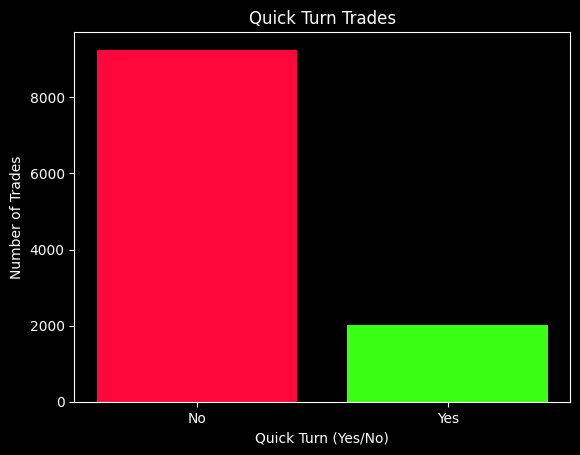

In [10]:
import matplotlib.pyplot as plt

# Count the occurrences of True and False in the 'Quick Turn' column
turn_counts = df['Quick Turn'].value_counts()

# Plot the bar chart
plt.bar(['No', 'Yes'], turn_counts, color=['#FF073A', '#39FF14'])
plt.title('Quick Turn Trades')
plt.xlabel('Quick Turn (Yes/No)')
plt.ylabel('Number of Trades')
plt.show()

In [11]:
# Calculate the holding time for each position
# Group by Instrument and calculate the average holding time
average_holding_time = df.groupby('Instrument')['Time_Last_Trade'].mean()

# Define short and long term thresholds
short_term_threshold = pd.Timedelta(minutes=5)
long_term_threshold = pd.Timedelta(days=1)

# Classify each trade as short, long, or average term
conditions = [
    df['Time_Last_Trade'] <= short_term_threshold,
    df['Time_Last_Trade'] >= long_term_threshold
]
choices = ['Short Term', 'Long Term']
df['Holding Term'] = pd.Series(pd.cut(df['Time_Last_Trade'], bins=[pd.Timedelta(0), short_term_threshold, long_term_threshold, pd.Timedelta.max], labels=['Short Term', 'Average Term', 'Long Term'], right=False))

# Count the number of short, long, and average term holdings for each instrument
holding_counts = df.groupby(['Instrument', 'Holding Term']).size().unstack(fill_value=0)

average_holding_time, holding_counts

/tmp/ipykernel_850/3088728556.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  holding_counts = df.groupby(['Instrument', 'Holding Term']).size().unstack(fill_value=0)


(Instrument
 EUR/USD   0 days 00:17:28.297872340
 GBP/USD                         NaT
 XAU/USD   0 days 00:11:29.129146919
 Name: Time_Last_Trade, dtype: timedelta64[ns],
 Holding Term  Short Term  Average Term  Long Term
 Instrument                                       
 EUR/USD             4254           244         14
 GBP/USD                0             0          0
 XAU/USD             5960           784          8)

The analysis of position holding times for each instrument is as follows:

1. **Average Holding Time**:
   - EUR/USD: Approximately 17 minutes and 28 seconds.
   - GBP/USD: No data available.
   - XAU/USD: Approximately 11 minutes and 29 seconds.

2. **Holding Term Counts**:
   - EUR/USD: 4254 short-term, 244 average-term, and 14 long-term holdings.
   - GBP/USD: No data available.
   - XAU/USD: 5960 short-term, 784 average-term, and 8 long-term holdings.

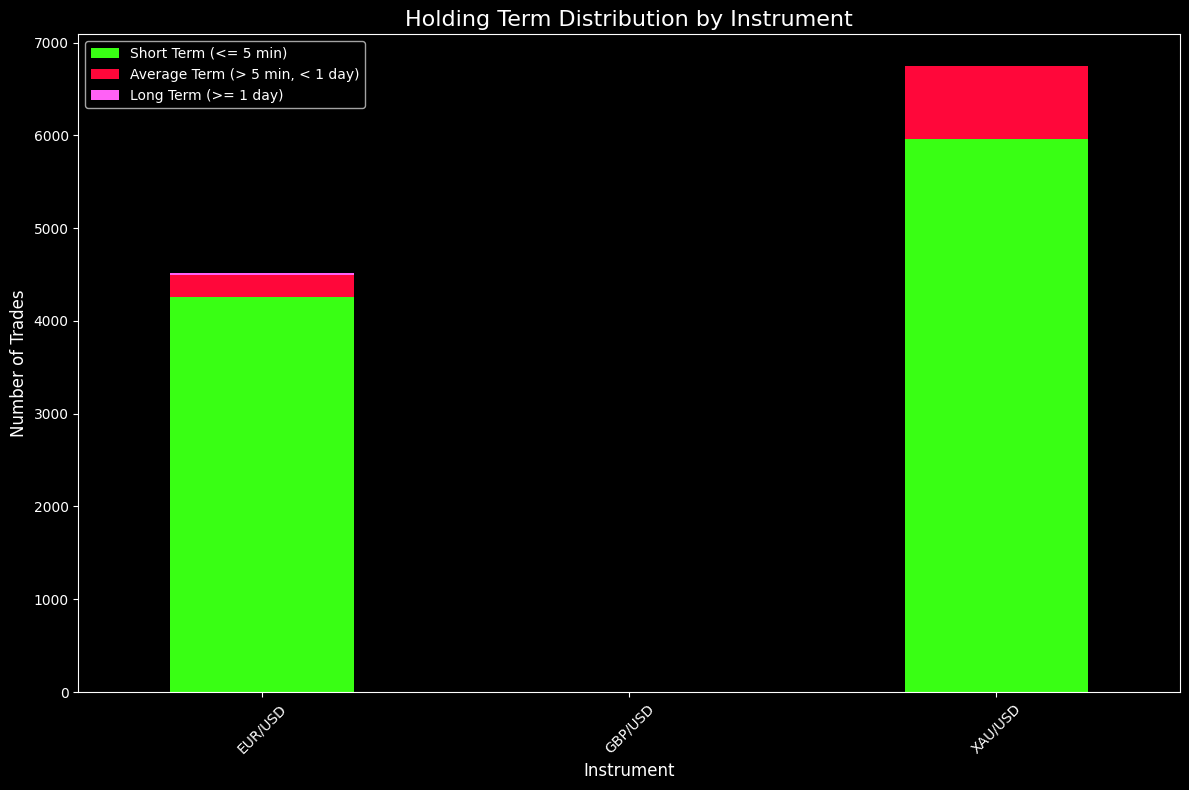

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Set the style for the plot
plt.style.use('dark_background')

# Define neon colors for the bars
neon_colors = ['#39FF14', '#FF073A', '#FF61F6']

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the holding counts for each instrument
holding_counts.plot(kind='bar', stacked=True, color=neon_colors, ax=ax)

# Set the title and labels
ax.set_title('Holding Term Distribution by Instrument', fontsize=16)
ax.set_xlabel('Instrument', fontsize=12)
ax.set_ylabel('Number of Trades', fontsize=12)

# Add a legend with the criteria for each term
ax.legend(['Short Term (<= 5 min)', 'Average Term (> 5 min, < 1 day)', 'Long Term (>= 1 day)'], fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [19]:
# Create the Excel file with separate tabs
with pd.ExcelWriter('AugSept_Analysis_Complete.xlsx', engine='openpyxl') as writer:
    # All summarized data first
    df.to_excel(writer, sheet_name='All_Trade_Detail', index=False)
    # granular data
    monthly_df.to_excel(writer, sheet_name='Monthly_Summary', index=False)
    weekly_df.to_excel(writer, sheet_name='Weekly_Summary', index=False)
    daily_df.to_excel(writer, sheet_name='Daily_Summary', index=False)
    

print("Report generated successfully!")

Report generated successfully!


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ca4e7556-7ab0-4f97-a005-0c4324247595' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>